In [1]:
from langchain_aws import ChatBedrockConverse
from langchain.schema import HumanMessage, SystemMessage
import boto3
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from opensearchpy import OpenSearch, RequestsHttpConnection
import os
import boto3
import json
import sys
from langchain.schema import BaseRetriever, Document
from typing import List, Optional, Dict, Tuple , TypedDict ,Annotated
from langchain_core.documents import Document
import fitz
import concurrent.futures
from langchain_aws import BedrockEmbeddings
from langchain_core.runnables import RunnableParallel, RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate
from langchain.prompts.prompt import PromptTemplate
from operator import itemgetter
from langchain_core.runnables import RunnableLambda
from pydantic import BaseModel, Field ,ValidationError

import re
import requests
from bs4 import BeautifulSoup
from langchain.agents import tool
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles


In [2]:
#https://app.tavily.com/sign-in

In [3]:
bedrock_client = boto3.client(
    service_name='bedrock-runtime',
    region_name='us-east-1'  # replace with your region
)
llm = ChatBedrockConverse(
    model_id="anthropic.claude-3-sonnet-20240229-v1:0",
    client=bedrock_client,
    temperature=0.7,
    max_tokens=2000
)

In [4]:
def visualize(graph):
    display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
    )

In [5]:
class Employee(BaseModel):
    id: Annotated[int, Field(..., description="직원 ID")]
    name: Annotated[str, Field(..., min_length=3, max_length=50, description="이름")]
    age: Annotated[int, Field(gt=18, lt=65, description="나이 (19-64세)")]
    salary: Annotated[
        float, Field(gt=0, lt=10000, description="연봉 (단위: 만원, 최대 10억)")
    ]
    skills: Annotated[
        List[str], Field(min_items=1, max_items=10, description="보유 기술 (1-10개)")
    ]

In [6]:
try:
    valid_employee = Employee(
        id=1, name="테디노트", age=30, salary=1000, skills=["Python", "LangChain"]
    )
    print("유효한 직원 데이터:", valid_employee)
except ValidationError as e:
    print("유효성 검사 오류:", e)

유효한 직원 데이터: id=1 name='테디노트' age=30 salary=1000.0 skills=['Python', 'LangChain']


In [7]:
try:
    invalid_employee = Employee(
        name="테디",  # 이름이 너무 짧음
        age=17,  # 나이가 범위를 벗어남
        salary=20000,  # 급여가 범위를 벗어남
        skills="Python",  # 리스트가 아님
    )
except ValidationError as e:
    print("유효성 검사 오류:")
    for error in e.errors():
        print(f"- {error['loc'][0]}: {error['msg']}")


유효성 검사 오류:
- id: Field required
- name: String should have at least 3 characters
- age: Input should be greater than 18
- salary: Input should be less than 10000
- skills: Input should be a valid list


In [8]:

from langchain_core.messages import AIMessage, HumanMessage
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [9]:
msgs1 = [HumanMessage(content="안녕하세요?", id="1")]
msgs2 = [AIMessage(content="반갑습니다~", id="2")]

result1 = add_messages(msgs1, msgs2)
print(result1)


[HumanMessage(content='안녕하세요?', additional_kwargs={}, response_metadata={}, id='1'), AIMessage(content='반갑습니다~', additional_kwargs={}, response_metadata={}, id='2')]


In [10]:


class State(TypedDict):
    # 메시지 정의(list type 이며 add_messages 함수를 사용하여 메시지를 추가)
    messages: Annotated[list, add_messages]

In [11]:
# def chatbot(state: State):
#     print("check_point -> ",state["messages"])
#     # 메시지 호출 및 반환
#     return {"messages": [llm.invoke(state["messages"])]}

def chatbot(state: State) -> State:
    messages = state["messages"]
    
    # Convert to format LLM expects if needed
    formatted_messages = []
    for msg in messages:
        if isinstance(msg, tuple):
            role, content = msg
            if role == "user":
                formatted_messages.append(HumanMessage(content=content))
            else:
                formatted_messages.append(AIMessage(content=content))
        else:
            formatted_messages.append(msg)
    
    response = llm.invoke(formatted_messages)
    
    # Return in tuple format
    return {"messages": [("assistant", response.content)]}



In [12]:
# def chatbottwo(state: State) -> State:
#     print("check_point_2 -> ", state["messages"])
#     # Get the last assistant message which should contain the top 10 list
#     last_message = None
#     for content in state["messages"]:
#         last_message = content
    
#     if not last_message:
#         return {"messages": [("assistant", "I don't have any recommendations to filter.")]}
    
#     # Create a prompt to select top 3
#     prompt_select_three = ChatPromptTemplate.from_template("""
#     {information}
    
#     이 정보를 바탕으로 10개의 리스트 중 가장 유명한 세개만 알려주세요
#     """)
    
#     # Create a chain
#     chaintest = prompt_select_three | llm | StrOutputParser()
    
#     # Get the top 3 recommendations
#     top_three = chaintest.invoke({"information": last_message})
    
#     # Return as a message
#     return {"messages": [("assistant", top_three)]}

def chatbottwo(state: State) -> State:
    print("check_point_2 -> ", state["messages"])
    
    # Get the last assistant message which should contain the top 10 list
    last_message = None
    for message in state["messages"]:
        # Check if it's a LangChain message object
        if hasattr(message, 'content') and hasattr(message, '__class__') and message.__class__.__name__ == 'AIMessage':
            last_message = message.content
        # Check if it's a tuple with role and content
        elif isinstance(message, tuple) and len(message) == 2 and message[0] == "assistant":
            last_message = message[1]
    
    if not last_message:
        return {"messages": [("assistant", "I don't have any recommendations to filter.")]}
    
    # Create a prompt to select top 3
    prompt_select_three = ChatPromptTemplate.from_template("""
    {information}
    
    이 정보를 바탕으로 10개의 리스트 중 가장 유명한 세개만 알려주세요
    """)
    
    # Create a chain
    chaintest = prompt_select_three | llm | StrOutputParser()
    
    # Get the top 3 recommendations
    top_three = chaintest.invoke({"information": last_message})
    
    # Return as a message - use the same format as your input
    # If you're using tuples when invoking the graph:
    return {"messages": [("assistant", top_three)]}

In [13]:
graph_builder = StateGraph(State)


graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("chatbottwo", chatbottwo)


In [14]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", "chatbottwo")
graph_builder.add_edge("chatbottwo", END)


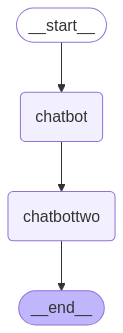

In [15]:
graph = graph_builder.compile()

visualize(graph)

In [16]:

question = "서울의 유명한 맛집 TOP 10 추천해줘"

# # 그래프 이벤트 스트리밍
# for event in graph.stream({"messages": [("user", question)]}):
#     # 이벤트 값 출력
#     for value in event.values():
#         print("Assistant:", value["messages"][-1].content)

response=graph.invoke({"messages": [("user", question)]})


check_point_2 ->  [HumanMessage(content='서울의 유명한 맛집 TOP 10 추천해줘', additional_kwargs={}, response_metadata={}, id='37280f62-1036-4f48-981c-7760a785d05e'), AIMessage(content='서울에는 정말 다양한 맛집들이 있습니다. 여기 제가 추천하는 서울의 유명 맛집 TOP 10을 소개해 드리겠습니다.\n\n1. 빈나박\n2. 구이구이\n3. 봉피양\n4. 장수촌\n5. 한남동 맛나분식\n6. 산정동 순두부\n7. 해물탕 하우스\n8. 온가족 숯불갈비\n9. 마마무 족발\n10. 서울바스타\n\n이 맛집들은 서울 사람들 사이에서 오랫동안 유명했고, 많은 사람들이 추천하는 곳들입니다. 한식, 중식, 일식, 분식 등 다양한 종류의 맛집들이 포함되어 있습니다. 취향에 맞게 골라보시면 좋을 것 같네요. 서울 여행 오셨을 때 꼭 들러보시기 바랍니다!', additional_kwargs={}, response_metadata={}, id='2fa884ab-5471-4ca7-8aba-1ac23cc38dd3')]


In [17]:
response

{'messages': [HumanMessage(content='서울의 유명한 맛집 TOP 10 추천해줘', additional_kwargs={}, response_metadata={}, id='37280f62-1036-4f48-981c-7760a785d05e'),
  AIMessage(content='서울에는 정말 다양한 맛집들이 있습니다. 여기 제가 추천하는 서울의 유명 맛집 TOP 10을 소개해 드리겠습니다.\n\n1. 빈나박\n2. 구이구이\n3. 봉피양\n4. 장수촌\n5. 한남동 맛나분식\n6. 산정동 순두부\n7. 해물탕 하우스\n8. 온가족 숯불갈비\n9. 마마무 족발\n10. 서울바스타\n\n이 맛집들은 서울 사람들 사이에서 오랫동안 유명했고, 많은 사람들이 추천하는 곳들입니다. 한식, 중식, 일식, 분식 등 다양한 종류의 맛집들이 포함되어 있습니다. 취향에 맞게 골라보시면 좋을 것 같네요. 서울 여행 오셨을 때 꼭 들러보시기 바랍니다!', additional_kwargs={}, response_metadata={}, id='2fa884ab-5471-4ca7-8aba-1ac23cc38dd3'),
  AIMessage(content='제가 제공한 서울 유명 맛집 10곳 중에서 가장 유명한 세 곳은 다음과 같습니다:\n\n1. 빈나박\n2. 구이구이  \n3. 봉피양\n\n빈나박은 서울에서 가장 유명한 북경식 민가집으로, 오랜 전통과 맛으로 많은 사람들에게 사랑받고 있습니다. \n\n구이구이는 서울 대표 삼겹살 구이 전문점으로, 맛과 서비스 모두 뛰어납니다.\n\n봉피양은 서울에서 가장 유명한 중식당 중 하나로, 특히 소갈비탕과 잡채가 유명합니다.\n\n이렇게 오랜 역사와 전통을 자랑하며 많은 사람들에게 인정받고 있는 맛집들이 서울에서 가장 유명한 곳이라고 할 수 있겠습니다.', additional_kwargs={}, response_metadata={}, id='d08738d9-928d-4880-aa51-b7de94a33925')]}

In [19]:
question = "서울의 유명한 관광명소 TOP 10 추천해줘"

# # Stream the graph execution
# for event in graph.stream({"messages": [("user", question)]}):
#     # Get the node name and state
#     node_name = list(event.keys())[0]
#     state = list(event.values())[0]
    
#     print(f"Node: {node_name}")
#     print("-" * 50)
    
#     # Display the last message from this node
#     if state["messages"] and len(state["messages"]) > 0:
#         last_message = state["messages"][-1]
        
#         # Check the type of message and extract content accordingly
#         if hasattr(last_message, 'content'):
#             # It's a LangChain message object
#             role = last_message.__class__.__name__.replace('Message', '')
#             content = last_message.content
#         elif isinstance(last_message, tuple) and len(last_message) == 2:
#             # It's a tuple of (role, content)
#             role, content = last_message
#         else:
#             # Unknown format, just print the message
#             print(f"Message: {last_message}")
#             continue
        
#         # Print the full content
#         print(f"{role}: {content}")
    
#     print("-" * 50)
#     print()  # Add an extra line for better readability


# Stream the graph execution using tuples
for event in graph.stream({"messages": [("user", question)]}):
    # Get the node name and state
    node_name = list(event.keys())[0]
    state = list(event.values())[0]
    
    print(f"Node: {node_name}")
    print("-" * 50)
    
    # Display the last message from this node
    if state["messages"] and len(state["messages"]) > 0:
        last_message = state["messages"][-1]
        
        # Handle different message formats
        if hasattr(last_message, 'content'):
            # It's a LangChain message object
            role = last_message.__class__.__name__.replace('Message', '')
            content = last_message.content
        elif isinstance(last_message, tuple) and len(last_message) == 2:
            # It's a tuple of (role, content)
            role, content = last_message
        else:
            # Unknown format, just print the message
            print(f"Message: {last_message}")
            continue
        
        # Print the full content
        print(f"{role}: {content}")
    
    print("-" * 50)
    print()  # Add an extra line for better readability


Node: chatbot
--------------------------------------------------
assistant: 서울에는 오랜 역사와 현대적인 매력이 공존하는 다양한 관광명소가 있습니다. 여기 서울 관광의 꽃이라고 할 수 있는 유명 관광지 10곳을 추천해 드리겠습니다.

1. 경복궁 - 조선시대 왕궁으로 아름다운 건축물과 정원이 있습니다.

2. 남산 서울타워 - 서울의 상징적인 곳으로 전망대에서 서울 시내를 한눈에 내려다 볼 수 있습니다. 

3. 인사동 - 전통 한국문화를 체험할 수 있는 거리로 갤러리, 공방, 전통차집 등이 있습니다.

4. 동대문디자인플라자(DDP) - 현대적 건축미가 돋보이는 복합문화공간입니다.

5. 북촌한옥마을 - 조선시대 가옥들이 잘 보존된 전통마을입니다.

6. 광화문광장 - 서울의 관문으로 세종대왕 동상, 광화문 등 볼거리가 많습니다.

7. 이태원 거리 - 다양한 외국 문화를 체험할 수 있는 활기찬 거리입니다.  

8. 청계천 - 도심 속 생태하천으로 산책하기 좋은 공간입니다.

9. 홍대 앞 거리 - 젊음의 거리로 다양한 클럽, 공연장, 상점들이 있습니다.

10. 여의도 한강공원 - 한강을 조망할 수 있는 넓은 공원입니다.

이 곳들을 둘러보면 서울의 전통과 현대를 고루 느낄 수 있을 것입니다.
--------------------------------------------------

check_point_2 ->  [HumanMessage(content='서울의 유명한 관광명소 TOP 10 추천해줘', additional_kwargs={}, response_metadata={}, id='e0edeaf3-43af-4140-8908-7382b6adf9f5'), AIMessage(content='서울에는 오랜 역사와 현대적인 매력이 공존하는 다양한 관광명소가 있습니다. 여기 서울 관광의 꽃이라고 할 수 있는 유명 관광지 10곳을 추천해 드리겠습니다.\n\n1. 경복궁 - 조선시대 왕궁으로 아름다운 

In [25]:
graph_builder = StateGraph(State)


In [26]:
class State(TypedDict):
    # list 타입에 add_messages 적용(list 에 message 추가)
    messages: Annotated[list, add_messages]

In [27]:
# Try this first
from langchain_community.tools.tavily_search import TavilySearchResults
# Import the Tool class from langchain
from langchain.tools import tool  # Note: lowercase 'tool' for the decorator

os.environ["TAVILY_API_KEY"] = "XXXXX"
search_tool = TavilySearchResults()

@tool(
    description="Search the web for information using Tavily search engine"
)
def search_tavily(question):
    # Use the tool to search
    search_results = search_tool.invoke(question)
    return search_results


tools = [search_tavily]


search_tavily

StructuredTool(name='search_tavily', description='Search the web for information using Tavily search engine', args_schema=<class 'langchain_core.utils.pydantic.search_tavily'>, func=<function search_tavily at 0x7fb6c28027a0>)

In [28]:
llm_with_tools = llm.bind_tools(tools)


In [29]:
def chatbot(state: State):
    answer = llm_with_tools.invoke(state["messages"])
    # 메시지 목록 반환
    return {"messages": [answer]}  # 자동으로 add_messages 적용

In [30]:
graph_builder.add_node("chatbot", chatbot)


In [32]:
import json
from langchain_core.messages import ToolMessage


class BasicToolNode:
    """Run tools requested in the last AIMessage node"""

    def __init__(self, tools: list) -> None:
        # 도구 리스트
        self.tools_list = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        print("simple check -> ",inputs)
        print()
        # 메시지가 존재할 경우 가장 최근 메시지 1개 추출
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")

        # 도구 호출 결과
        outputs = []
        for tool_call in message.tool_calls:
            # 도구 호출 후 결과 저장
            tool_result = self.tools_list[tool_call["name"]].invoke(tool_call["args"])
            outputs.append(
                # 도구 호출 결과를 메시지로 저장
                ToolMessage(
                    content=json.dumps(
                        tool_result, ensure_ascii=False
                    ),  # 도구 호출 결과를 문자열로 변환
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )

        return {"messages": outputs}


tool_node = BasicToolNode(tools=[search_tavily])


graph_builder.add_node("tools", tool_node)



In [33]:
from langgraph.graph import START, END


def route_tools(
    state: State,
):
    if messages := state.get("messages", []):
        # 가장 최근 AI 메시지 추출
        ai_message = messages[-1]
    else:
        # 입력 상태에 메시지가 없는 경우 예외 발생
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    # AI 메시지에 도구 호출이 있는 경우 "tools" 반환
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        # 도구 호출이 있는 경우 "tools" 반환
        return "tools"
    # 도구 호출이 없는 경우 "END" 반환
    return END


# `tools_condition` 함수는 챗봇이 도구 사용을 요청하면 "tools"를 반환하고, 직접 응답이 가능한 경우 "END"를 반환
graph_builder.add_conditional_edges(
    source="chatbot",
    path=route_tools,
    # route_tools 의 반환값이 "tools" 인 경우 "tools" 노드로, 그렇지 않으면 END 노드로 라우팅
    path_map={"tools": "tools", END: END},
)

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# 그래프 컴파일
graph = graph_builder.compile()



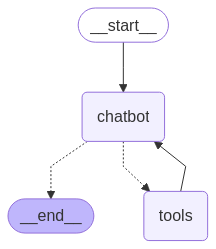

In [34]:
visualize(graph)

In [35]:
inputs = {"messages": "테디노트 YouTube 채널에 대해서 검색해 줘"}

for event in graph.stream(inputs, stream_mode="values"):
    for key, value in event.items():
        print(f"\n==============\nSTEP: {key}\n==============\n")
        # display_message_tree(value["messages"][-1])
        print(value[-1])



STEP: messages

content='테디노트 YouTube 채널에 대해서 검색해 줘' additional_kwargs={} response_metadata={} id='74d42445-57be-44f2-b89e-8fe9d24c2f9a'

STEP: messages

content=[{'type': 'text', 'text': '물론입니다. 테디노트 YouTube 채널에 대한 정보를 찾아보겠습니다.'}, {'type': 'tool_use', 'name': 'search_tavily', 'input': {'question': '테디노트 YouTube 채널'}, 'id': 'tooluse_P-EV_I5YSw6SMh7TBdjbzQ'}] additional_kwargs={} response_metadata={'ResponseMetadata': {'RequestId': 'b1aa0623-358a-4234-b8a4-7dcb6c5c2e94', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Sun, 04 May 2025 08:36:21 GMT', 'content-type': 'application/json', 'content-length': '404', 'connection': 'keep-alive', 'x-amzn-requestid': 'b1aa0623-358a-4234-b8a4-7dcb6c5c2e94'}, 'RetryAttempts': 0}, 'stopReason': 'tool_use', 'metrics': {'latencyMs': [1487]}, 'model_name': 'anthropic.claude-3-sonnet-20240229-v1:0'} id='run--7247c268-fcae-48b1-8986-2b76592bb683-0' tool_calls=[{'name': 'search_tavily', 'args': {'question': '테디노트 YouTube 채널'}, 'id': 'tooluse_P-EV_I5YSw6SM